In [263]:
%load_ext autoreload
%autoreload
%matplotlib notebook

In [295]:
import numpy as np
import geopandas as gpd
import rasterio as rio
import rasterio.features
from matplotlib import pyplot as plt
from pyproj import CRS, Transformer
import osmnx as ox
from shapely import affinity
from shapely.geometry import Point, Polygon, MultiPolygon
from shapely.ops import transform as shp_transform
from skimage.segmentation import watershed
from skimage.io import imsave
from skimage.measure import find_contours
import cv2 as cv

In [236]:
height_map_path = "../../../data/DTM_Ahrweiler.tif"

In [237]:
hm_ds = rio.open(height_map_path)

In [238]:
hm_ds.crs

CRS.from_epsg(25832)

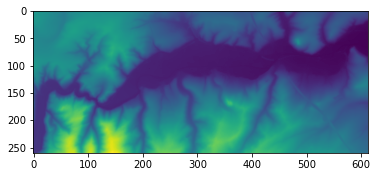

In [239]:
hm = hm_ds.read(1)
plt.imshow(hm)

In [240]:
bounds = hm_ds.bounds

In [241]:
bounds

BoundingBox(left=360817.8905, bottom=5597503.8953, right=373077.8905, top=5602703.8953)

In [242]:
hm_ds.crs

CRS.from_epsg(25832)

In [243]:
osm_crs = CRS.from_epsg(4326)
hm_osm_trans = Transformer.from_crs(hm_ds.crs, osm_crs, always_xy=True)
osm_hm_trans = Transformer.from_crs(osm_crs, hm_ds.crs, always_xy=True)
bl = hm_osm_trans.transform(bounds[0], bounds[1])
tr = hm_osm_trans.transform(bounds[2], bounds[3])
bbox = (bl[1], tr[1], bl[0], tr[0])
#bbox = (7.147178,50.542931, 7.148191,50.543862)
tags = {"waterway": True}
geom = ox.geometries.geometries_from_bbox(*bbox, tags)

/home/tobias/miniconda3/envs/hz/lib/python3.7/site-packages/geopandas/_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
/home/tobias/miniconda3/envs/hz/lib/python3.7/site-packages/geopandas/_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out


In [244]:
rivers = geom[geom['waterway']=='river']
rivers_geom = rivers.geometry

In [245]:
mat = np.array(hm_ds.transform).reshape((3,3))
mat = np.linalg.inv(mat)
mat = mat.flatten()[:6]
mat = [*mat[:2], *mat[3:5], mat[2], mat[5]]
river_mask = np.zeros(hm.shape, dtype=bool)
for r in rivers_geom:
    r = shp_transform(osm_hm_trans.transform, r)
    r = affinity.affine_transform(r, mat)
    river_mask |= rio.features.rasterize((r, 1), out_shape=hm.shape).astype(bool)

/home/tobias/miniconda3/envs/hz/lib/python3.7/site-packages/rasterio/features.py:318: ShapeSkipWarning: Invalid or empty shape 1 at index 1 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.format(geom, index), ShapeSkipWarning)


In [247]:
max_river_bed = hm[river_mask].max()
water_height = 10
for i, water_height in enumerate(np.linspace(-50,75,240)):
    height_mask = hm <= max_river_bed + water_height
    res = watershed(hm, river_mask, mask=height_mask) * 200
    rgb = res.copy()
    rgb -= rgb.min()
    rgb = (rgb / rgb.max() * 255).astype(np.uint8)
    rgb = np.stack((hm,hm,hm), axis = 2)
    rgb[:,:,2] = res

In [233]:
tmp = np.ones((10,10))

In [234]:
find_contours(tmp, level=0.5)

[]

<IPython.core.display.Javascript object>


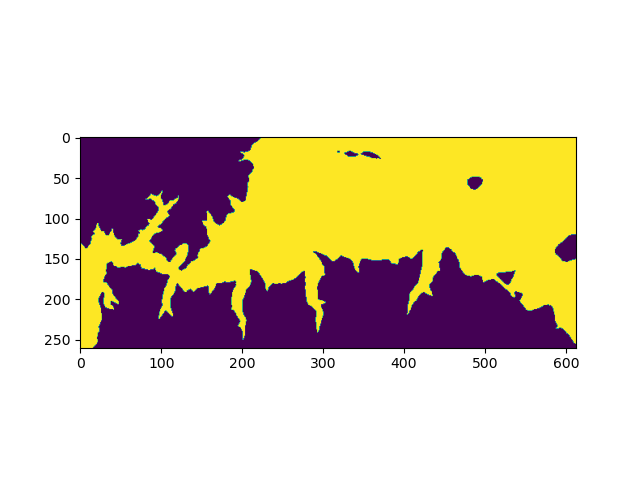

In [315]:
plt.imshow(res)

In [344]:
res = (res > 0).astype(np.uint8)
cnts, hier = cv.findContours(res, mode=cv.RETR_CCOMP, method=cv.CHAIN_APPROX_TC89_KCOS)
holes = [[] for t in hier[0]]
for i,h in enumerate(hier[0]):
    if h[3] >= 0 and cnts[i].shape[0] >= 3:
        holes[h[3]].append(np.squeeze(cnts[i]))
polys = []
for i, cnt in enumerate(cnts):
    if hier[0,i,3]==-1:
        shell = np.squeeze(cnt)
        shell_holes = holes[i]
        if shell.shape[0] >= 3:
            polys.append(Polygon(shell, shell_holes))

In [336]:
tmp = poly.interiors

In [341]:
polys_json = []
for poly in polys:
    poly_json = {}
    shell = poly.exterior
    xy = shell.xy
    if shell.is_ccw:
        xy = (xy[0][::-1], xy[1][::-1])
    xy_json = {"x": xy[0], "y":xy[1]}
    poly_json['shell'] = xy_json
    holes = []
    for hole in poly.interiors:
        xy = hole.xy
        if not hole.is_ccw:
            xy = (xy[0][::-1], xy[1][::-1])
        xy_json = {"x": xy[0], "y":xy[1]}
        holes.append(xy_json)
    poly_json['holes']=holes
    polys_json.append(poly_json)
poly_json = {"polygons": poly_json}